<a href="https://colab.research.google.com/github/KostaKat/MAT442/blob/main/hw2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Maximum likelihood estimation (MLE)** is used for estimating parameters of a probability distribution. The best values for these parameters are determined by maximizing the "likelihood function" which is defined as the probability of the observational data given the parameters.

The main idea of MLE is to identify the set of parameters that best fit the data. Essentially, you modify the parameters to align your model's predictions with the actual data as closely as possible.

The likelihood function is:
$$
f(x_1, \ldots, x_n; \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x_1 - \mu)^2}{2\sigma^2}} \cdots \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x_n - \mu)^2}{2\sigma^2}}
$$

This simplifies to:
$$
f(x_1, \ldots, x_n; \mu, \sigma^2) = \left( \frac{1}{\sqrt{2 \pi \sigma^2}} \right)^{n/2} e^{-\frac{\sum_{i=1}^n (x_i - \mu)^2}{2\sigma^2}}
$$

The log-likelihood function is:
$$
\ln \left[ f(x_1, \ldots, x_n; \mu, \sigma^2) \right] = -\frac{n}{2} \ln(2 \pi \sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^n (x_i - \mu)^2
$$

### Example: Normal Distribution
Let's say you have a set of observations $ X_1, X_2, ..., X_n $, all  from a normal distribution with an unknown mean $ \mu$ and variance $ \sigma^2$.




#### Solving for MLEs
To find the maximum likelihood estimates (MLEs) for $\mu$ and $ \sigma^2$, we take the partial derivate of  the log-likelihood with respect to each parameter and solve for the values that maximize the function.

1. **MLE for $\mu$**:
$$
 \hat{\mu} = \frac{1}{n} \sum_{i=1}^n X_i
$$
This is essentially the sample mean
2. **MLE for $\sigma^2$**:
$$
   \hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^n (X_i - \hat{\mu})^2
$$
This is essentially the sample variance.

In conclusion, the MLEs for a normal distribution's parameters are:
$$
\hat{\mu} = \bar{X} \quad \text{and} \quad \hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^n (X_i - \bar{X})^2
$$

MLE is a powerful tool for machine learning and is used in many classical machine learning models, including linear regression, logistical regression, hidden Markov models, Naive Bayes, Gaussian Mixture Models, generalized linear Models, and Support Vector Machines.



In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Gaussian Mixture Model (GMM) implemented using the Expectation-Maximization (EM) algorithm
# The GMM is a probabilistic model assuming all data points are generated from a mixture of several Gaussian distributions
# The EM algorithm iteratively finds maximum likelihood estimates of the parameters
# This is a generalization of k-means, and is an unsupervised learning algorithm for clustering
class GMM:
    def __init__(self, n_components, max_iter=200, tol=1e-6, reg_covar=1e-6):

        self.n_components = n_components        # Number of Gaussian components
        self.max_iter = max_iter                # Maximum number of iterations for EM
        self.tol = tol                          # Tolerance to check convergence
        self.reg_covar = reg_covar              # Regularization term to ensure covariance matrices are positive definite

    def initialize_parameters(self, X):

        np.random.seed(0)
        n_samples, n_features = X.shape
        self.weights = np.ones(self.n_components) / self.n_components                       # Initialize weights equally
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]       # Randomly choose initial means
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)]) # Identity matrix for covariance

    def e_step(self, X):
        # E-step: Calculate responsibilities (posterior probabilities)
        n_samples = X.shape[0]
        self.resp = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            # Compute probability of each data point belonging to each Gaussian component
            self.resp[:, k] = self.weights[k] * multivariate_normal(mean=self.means[k], cov=self.covariances[k]).pdf(X)

        # Normalize responsibilities so they sum to 1 for each data point
        self.resp /= self.resp.sum(axis=1, keepdims=True)

    def m_step(self, X):
        # M-step: Update the parameters using the current responsibilities
        n_samples, n_features = X.shape
        for k in range(self.n_components):
            resp_k = self.resp[:, k]                                                                # Responsibility for component k
            weight_sum = resp_k.sum()
            self.weights[k] = weight_sum / n_samples                                                # Update weights
            self.means[k] = (resp_k[:, np.newaxis] * X).sum(axis=0) / weight_sum                    # Update means
            centered_X = X - self.means[k]
            self.covariances[k] = (resp_k[:, np.newaxis] * centered_X).T @ centered_X / weight_sum  # Update covariances
            self.covariances[k] += self.reg_covar * np.eye(n_features)                              # Add regularization term to ensure positive definiteness

    def fit(self, X):
        # Fit the GMM to the data using the EM algorithm
        self.initialize_parameters(X)
        log_likelihood = -np.inf
        self.log_likelihoods = []

        for iteration in range(self.max_iter):
            # Perform E-step and M-step
            self.e_step(X)
            self.m_step(X)
            # Compute log-likelihood and check for convergence
            log_likelihood_new = self.compute_log_likelihood(X)
            self.log_likelihoods.append(log_likelihood_new)
            if abs(log_likelihood_new - log_likelihood) < self.tol:
                break
            log_likelihood = log_likelihood_new

    def compute_log_likelihood(self, X):
        # Compute the log-likelihood of the data given the current parameters
        log_likelihood = 0
        for k in range(self.n_components):
            log_likelihood += self.weights[k] * multivariate_normal(mean=self.means[k], cov=self.covariances[k]).pdf(X)
        return np.log(log_likelihood.sum())

    def predict(self, X):
        # Predict the labels for the data points
        self.e_step(X)
        return np.argmax(self.resp, axis=1)

    def predict_proba(self, X):
        # Predict the probabilities for each data point
        self.e_step(X)
        return self.resp




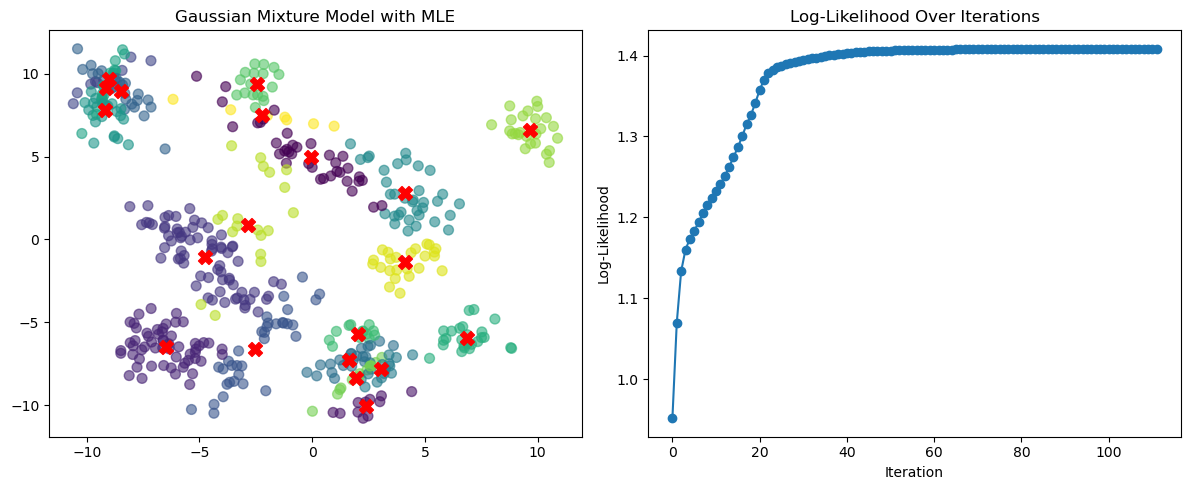

In [ ]:
# Generate synthetic dataset using make_blobs function with 20 clusters
X, _ = make_blobs(n_samples=500, centers=20, cluster_std=1.0, random_state=42)
# Fit GMM model using Maximum Likelihood Estimation (MLE)
gmm = GMM(n_components=20)
gmm.fit(X)
labels = gmm.predict(X)
# Plot the data with cluster assignments
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
plt.scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', marker='X', s=100)  # Plot cluster centers
plt.title('Gaussian Mixture Model with MLE')
# Plot the log-likelihood over iterations
plt.subplot(1, 3, 2)
plt.plot(range(len(gmm.log_likelihoods)), gmm.log_likelihoods, marker='o')
plt.title('Log-Likelihood Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.tight_layout()
plt.show()

### Linear Regression



Linear regression can be put into terms of probabilities. What are the steps of turning this into a problem of probabilities? Well, let's say that we have $n$ points, and these points are independently and identically distributed (i.i.d.) from a normal distribution. Furthermore, these points are independent of each other. It is apparent that each of these $n$ points and their predictions by a model can be presented by probabilities.

Before going any further here are some definitions we will use:
- data points are represented as  $(x_i, y_i)$ for $i = 1, \dots, n$, where $x_i$ represents the features and $y_i$ dependent variable
- predicted values are represented as  $\hat{y}_i$
- error terms are presented as $\epsilon$


Furthermore, we assume that each error value is normally distributed: $ \epsilon_i \sim N(0, \sigma^2) $. Additionally, each $ y_i = \hat{y}_i + \epsilon_i $. This means that $ y_i $ is also normally distributed around the predicted value:

$
y_i \sim N(\hat{y}_i , \sigma^2)
$

This can be thought of as $ \sigma^2 $ reflecting how much the original values of $ y_i $ vary around the predicted values. The variance $ \sigma^2 $ determines the spread of the distribution around the mean $ \hat{y}_i $.

Thus, weget the Likelihood Function:

$$
\mathcal{P}(\mu \mid y) = \prod_{i=1}^n p_Y(y_i \mid \mu, \sigma^2) = \prod_{i=1}^n \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(y_i - \mu)^2}{2\sigma^2}}
$$


Here is a proof found in the book that the least-square and max likelihood linear regression are equivalent:

$$
\hat{\beta} = \arg \max_\beta \mathcal{P}(\beta \mid y) = \arg \max_\beta \prod_{i=1}^n \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(y_i - \hat{y}_i)^2}{2\sigma^2}}
\\
= \arg \max_\beta \log \left( \prod_{i=1}^n \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(y_i - \hat{y}_i)^2}{2\sigma^2}} \right)
\\
= \arg \max_\beta \sum_{i=1}^n \log \left( \frac{1}{\sigma \sqrt{2\pi}} \right) + \log \left( e^{-\frac{(y_i - \hat{y}_i)^2}{2\sigma^2}} \right)
\\
= \arg \max_\beta \sum_{i=1}^n \left( \log \left( e^{-\frac{(y_i - \hat{y}_i)^2}{2\sigma^2}} \right) \right)
\\
= \arg \max_\beta \sum_{i=1}^n \frac{-(y_i - \hat{y}_i)^2}{2\sigma^2}
\\
= \arg \min_\beta \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

# Linear Regression implemented using Least Squares and Maximum Likelihood Estimation (MLE)
# We are visiting and old problem with a new approach
# Load the California housing dataset
california = fetch_california_housing()
X = california.data
y = california.target

# Select Median Income feature (for simplicity)
X = X[:, [0]].reshape(-1, 1)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Linear Regression using scikit-learn
# Create and fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
# Make predictions on the test data
y_pred_lr = model.predict(X_test)

# 2. Maximum Likelihood Estimation (MLE) for Linear Regression
# Define the negative log-likelihood function
# this is used in practice to find the optimal parameters by minimizing the negative log-likelihood
# this is equivalent to maximizing the likelihood of the data given the model
def negative_log_likelihood(beta, X, y, sigma=1.0):
    y_pred = X.dot(beta)
    residuals = y - y_pred
    n = len(y)
    return (n / 2) * np.log(2 * np.pi * sigma**2) + (1 / (2 * sigma**2)) * np.sum(residuals**2)

# Add a bias term to the features
X_train_bias = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test_bias = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

# Initialize beta parameters
initial_beta = np.zeros(X_train_bias.shape[1])

# Minimize the negative log-likelihood to find the optimal beta
result = minimize(negative_log_likelihood, initial_beta, args=(X_train_bias, y_train))

# Get the estimated parameters from the optimization result
beta_mle = result.x

# Predictions using MLE
y_pred_mle = X_test_bias.dot(beta_mle)



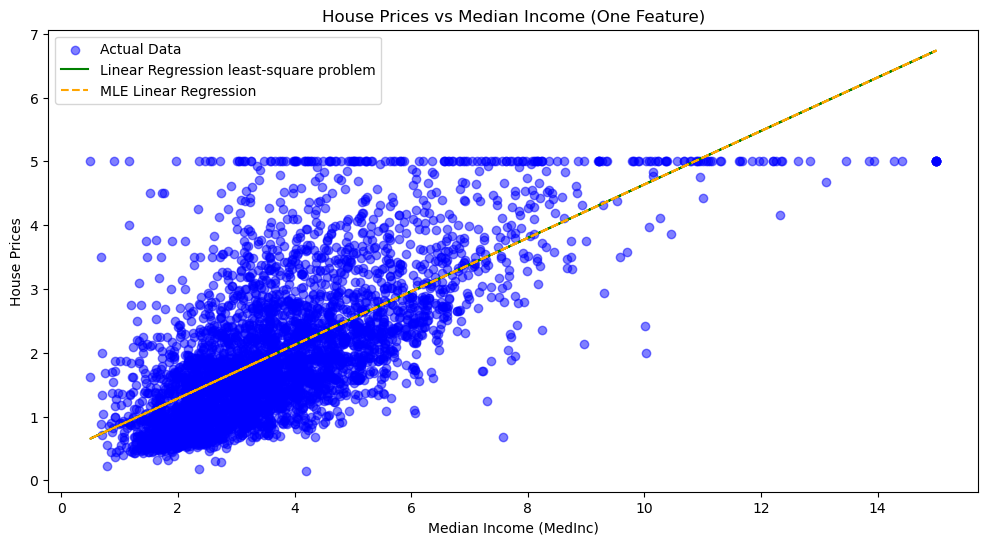

In [ ]:
# Plotting results
plt.figure(figsize=(12, 6))

# Plot actual data points
plt.scatter(X_test, y_test, label='Actual Data', color='blue', alpha=0.5)

# Plot predictions from Linear Regression
plt.plot(X_test, y_pred_lr, label='Linear Regression least-square problem', color='green', linestyle='solid')

# Plot predictions from MLE
plt.plot(X_test, y_pred_mle, label='MLE Linear Regression', color='orange', linestyle='dashed')

plt.title('House Prices vs Median Income (One Feature)')
plt.xlabel('Median Income (MedInc)')
plt.ylabel('House Prices')
plt.legend()
plt.show()

# the horizontal line at house price 5 due to the fact that the data is capped at 5. Source: https://medium.com/@basumatary18/implementing-linear-regression-on-california-housing-dataset-378e14e421b7
